In [88]:
import numpy as np
from scipy import io

In [89]:
data1 = io.loadmat('ex4data1.mat')
X = data1['X']
y = data1['y']
weights = io.loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

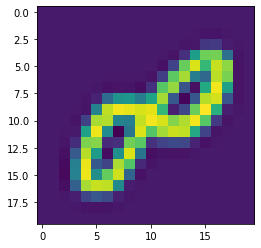

In [90]:
import matplotlib.pyplot as plt
import random
ax = plt.subplot(111)
index = random.randint(1,5000)
ax.imshow(X[index].reshape(20,20))
plt.show()

In [91]:
def serialization(y, classes):
    ret = np.zeros((y.shape[0],classes))
    for i,j in enumerate(y.ravel()):
        tmp = np.zeros((classes))
        tmp[j-1] = 1
        ret[i] = tmp
    return ret

In [92]:
serial_y = serialization(y, 10)
print(serial_y.shape)

(5000, 10)


In [93]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

In [94]:
def hTheta(theta1, theta2, x):
    output1 = sigmoid(np.dot(x, theta1.T))
    output1 = np.insert(output1, 0, 1, axis=1)
    output2 = sigmoid(np.dot(output1, theta2.T))
    return output2

def nnCostFunction(theta1, theta2, X, y):
    X = np.insert(X, 0, 1, axis=1)
    y = serialization(y, 10)
    loss = 0.0
    for i in range(X.shape[0]):
        X_i = np.matrix(X[i,:])
        y_i = np.matrix(y[i,:])
        theta1 = np.matrix(theta1)
        theta2 = np.matrix(theta2)
        pos = np.multiply(-y_i, np.log(hTheta(theta1, theta2, X_i)))
        neg = np.multiply((1-y_i), np.log(1-hTheta(theta1, theta2, X_i)))
        loss_i = np.sum(pos - neg)
        loss += loss_i
    loss /= len(y)
    return loss

In [95]:
print(nnCostFunction(theta1,theta2,X,y))

0.2876291651613188


In [96]:
def nnCostFunctionReg(theta1, theta2, X, y, r):
    X = np.insert(X, 0, 1, axis=1)
    y = serialization(y, 10)
    loss = 0.0
    for i in range(X.shape[0]):
        X_i = np.matrix(X[i,:])
        y_i = np.matrix(y[i,:])
        theta1 = np.matrix(theta1)
        theta2 = np.matrix(theta2)
        pos = np.multiply(-y_i, np.log(hTheta(theta1, theta2, X_i)))
        neg = np.multiply((1-y_i), np.log(1-hTheta(theta1, theta2, X_i)))
        loss_i = np.sum(pos - neg)
        loss += loss_i
    loss /= len(y)
    reg = (r / (2 * len(y))) * (np.sum(np.multiply(theta1,theta1)) + np.sum(np.multiply(theta2,theta2)))
    loss += reg
    return loss

def nnCostFunctionReg1(theta1, theta2, X, y, r):
    X = np.insert(X, 0, 1, axis=1)
    y = serialization(y, 10)
    pos = np.multiply(-y, np.log(hTheta(theta1,theta2,X)))
    neg = np.multiply((1-y),np.log(1-hTheta(theta1,theta2,X)))
    reg = (r / 2) * (np.sum(np.multiply(theta1,theta1)) + np.sum(np.multiply(theta2,theta2)))
    loss = (np.sum(pos - neg) + reg) / len(y)
    return loss

In [97]:
print(nnCostFunctionReg(theta1,theta2,X,y,1))
print(nnCostFunctionReg1(theta1,theta2,X,y,1))

0.38448779624289386
0.384487796242894


### 2.1 Sigmoid Gradient

In [98]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

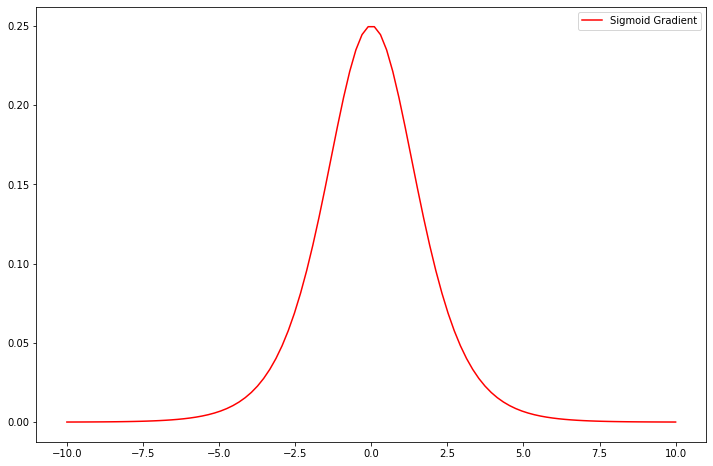

In [99]:
test_x = np.linspace(-10, 10, 100)
test_y = sigmoidGradient(test_x)
_, ax = plt.subplots(figsize=(12,8))
ax.plot(test_x, test_y, c='r', label='Sigmoid Gradient')
ax.legend(loc='best')
plt.show()

### 2.2 Random initialization

In [100]:
new_theta1 = (np.random.rand(theta1.shape[0],theta1.shape[1])-0.5)*0.24
new_theta2 = (np.random.rand(theta2.shape[0],theta2.shape[1])-0.5)*0.24

In [101]:
print(nnCostFunctionReg1(new_theta1,new_theta2,X,y,1))

6.80485315330218


In [102]:
print(new_theta2.shape)

(10, 26)


In [103]:
class Layers():
    def __init__(self, name):
        self.name = name
    def forward(self, x):
        pass
    def backward(self, grad_out):
        pass
    def update(self, lr=1e-3):
        pass
    def zero_grad(self):
        pass
    def comput_regularization(self):
        pass

class Model():
    def __init__(self):
        self.layers = []
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    def backward(self, grad):
        for layer in reversed(self.layers):
            layer.zero_grad()
            grad = layer.backward(grad)
    def step(self, lr=1e-3):
        for layer in reversed(self.layers):
            layer.update(lr)

In [104]:
class FC(Layers):
    def __init__(self, name, in_channels, out_channels, r=1):
        super(FC, self).__init__(name)
        self.weights = np.random.standard_normal((in_channels, out_channels))
        self.grad = np.zeros((in_channels, out_channels))
        self.r = r
    def forward(self, input):
        input = np.insert(input, 0, 1, axis=1)
        return sigmoid(np.dot(input, self.weights))
    def backward(self, grad):
        pass
    def comput_regularization(self):
        return (self.r / 2) * np.sum(np.multiply(self.weights, self.weights))
        

In [105]:
class Net(Model):
    def __init__(self):
        super(Net).__init__()
        self.layers = [
            FC(name='FC1', in_channels=401, out_channels=25),
            FC(name='FC2', in_channels=26, out_channels=10),
        ]

In [106]:
net = Net()
y_true = serialization(y, 10)
y_pred = net.forward(X)

In [107]:
class Loss():
    def __init__(self, name, net, r=1):
        self.net = net
        self.name = name
        self.r = r
    def compute(self, y_true, y_pred):
        pos = np.multiply(-y_true, np.log(y_pred))
        neg = np.multiply((1-y_true), np.log(1-y_pred))
        penalty = 0
        for layer in self.net.layers:
            penalty += layer.comput_regularization()
        return (np.sum(pos-neg) + penalty) / len(y_true)

In [108]:
loss = Loss('loss', net)
loss.compute(y_true, y_pred)

10.663313134500106

In [109]:
print(nnCostFunctionReg1(net.layers[0].weights.T,net.layers[1].weights.T,X,y,1))

10.663313134500106
